# TempAtt: exp1 (auditory)

### Load & preprocess data

In [87]:
clear
clc
% close all

In [88]:
% define Paths: replace XXX by your own path
origDir = '/XXX/exp1/'; %!
addpath(genpath(origDir)); cd(origDir)

% participants
SUJETS = 1:31;
SUJETS(SUJETS==9 ) = []; % to remove the unfinished participant

In [89]:
% load data: 2 sessions per participant
IN = []; Dif = NaN(SUJETS(end),1);
for isuj = SUJETS
    subject = ['S' sprintf( '%02d', isuj )];
        ifile = dir(['TA18_' subject '_1*.mat']);
        load([ifile.name])
        IN{isuj,1}  = X;
        Dif(isuj,1) = cfg.ndis;
    subject = ['S' sprintf( '%02d', isuj ) 'b'];
        ifile = dir(['TA18_' subject '_1*.mat']);
        load([ifile.name]) 
        IN{isuj,2}  = X;
        Dif(isuj,2) = cfg.ndis;
    clear X subject ifile
end
Dif = mean(Dif,2);

In [90]:
% varnames & beat
varname = {'Proportion Correct', 'Mean RT (ms)', 'Hit IE (sec)'};
beats = cfg.fbeat(end:-1:1);

In [91]:
% extract data: group 2 sessions, remove trials with suspect reaction times, average trials per condition
OUT{1} = NaN(SUJETS(end), length(cfg.fbeat)); OUT{2} = OUT{1}; OUT{3} = OUT{2};
for isuj = SUJETS
    for ibeat = 1:length(beats)
        out = [];
        for isess = 1:2 %!
            y = IN{isuj,isess}.beat == beats(ibeat);
            out{1}(isess,:) = IN{isuj,isess}.iscor(y);
            out{2}(isess,:) = IN{isuj,isess}.rt(y);
        end
        % group 2 sessions
            out{1} = reshape(out{1},[],1);
            out{2} = reshape(out{2},[],1);        
        % nan rt >|< 2sd
            rtmin = mean(out{2}) -2*std(out{2});
            rtmax = mean(out{2}) +2*std(out{2});
            out{2}(out{2}>rtmax)  = NaN; out{2}(out{2}<rtmin) = NaN;
            out{1}(isnan(out{2})) = NaN;
        % avg trials
            OUT{1}(isuj,ibeat) = nanmean(out{1});
            OUT{2}(isuj,ibeat) = nanmean(out{2});
            OUT{3}(isuj,ibeat) = nanmean(out{2}) ./nanmean(out{1});
        clear out y rtmin rtmax
    end
end
clear IN  isuj ibeat isess

In [92]:
% remove the phantom (NaN) participant
OUT{1}(isnan(OUT{1}(:,1)),:) = [];
OUT{2}(isnan(OUT{2}(:,1)),:) = [];
OUT{3}(isnan(OUT{3}(:,1)),:) = [];
Dif(isnan(Dif)) = [];

In [93]:
% define variable of interest
i0 = 1; % performance (or RT, or IE, see varname)
fit_order = 3; % fit order (n = 3)

In [94]:
% Fits per subject - define after rstudio analysis
xVec = (beats(end):0.01:beats(1));
Fit = [];
for j0 = 1:length(OUT{i0})
    x = OUT{i0}(j0,:);
    x = polyfit(log(beats), x, fit_order);
    if fit_order == 3
        Fit(j0) = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    elseif fit_order == 2
        Fit(j0) = exp(-(x(2)./(2.*x(1)))); % order 2
    end
end
Fit = real(Fit)';
nsuj = length(Fit);

% save data for inter-experiment comparisons
save([origDir 'exp1_values.mat'], 'Fit', 'Dif');

In [95]:
% option: exclude outlier participants in the Fit
% olr = find((Fit>(mean(Fit)+4*std(Fit)))); % detect outliers (4std)
% [min(Fit), max(Fit)] % edit range of Fit fq
% % exclude outlier on all data types
%     nsuj = nsuj-numel(olr);
%     Dif(olr) = [];
%     Fit(olr) = [];
%     OUT{i0}(olr,:) = [];
% [min(Fit), max(Fit)] % new rang of Fit fq

### Statistics

In [96]:
% statistics
fprintf('\nParametric repeated-measure Anova on %s \n', varname{i0})
[~,F,~,~] = repanova(OUT{i0}, 8, {'Beat'});

% compute fit quality:
x = mean(OUT{i0},1);
    y = polyfit(log(beats), x, fit_order);
    y = polyval(y, log(beats));
[r,p] = corr(x', y', 'type', 'Spearman');
fprintf('\n%1.0fnd order fit: r2=%1.2f, p=%1.3f \n', fit_order, r*r, p)
length(x);
clear x y F


Parametric repeated-measure Anova on Proportion Correct 
Beat                 F(  7.00,203.00) =  15.277,	p = 0.0000

3nd order fit: r2=0.86, p=0.002 


### Figure

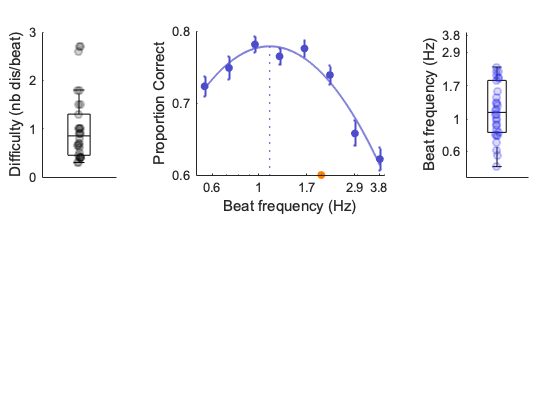

In [97]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])

% 1. Difficulty
h = subplot(2,4, 1); hold on
    pos = get(h, 'Position');
    set(h, 'Position', pos +[-.08 0 0 0] )
    boxplot(zeros(10,1), 'colors','k','Widths',.01)
boxplot(Dif,'boxstyle','outline', 'colors','k','OutlierSize',4,'Symbol','','Widths',0.6)
scatter(ones(size(Dif)).*(1+(rand(size(Dif))-0.5)/10),Dif, ...
    'MarkerFaceColor',[.1 .1 .1],'MarkerEdgeColor','k',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylim( [0, 3] )
    ylabel( 'Difficulty (nb dis/beat)' )
    xlim( [.0, 2] )
    set(gca,'XTick', [] )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    
    
% 3. boxplot individual preferred Fq
h = subplot(2,4, 4); hold on
    pos = get(h, 'Position');
    set(h, 'Position', pos +[.04 0 0 0] )
    boxplot(zeros(10,1), 'colors','k','Widths',.01)
boxplot(Fit, 'boxstyle','outline', 'colors','k','OutlierSize',4,'Symbol','','Widths',0.6)
scatter(ones(nsuj,1).*(1+(rand(nsuj,1)-0.5)/10), Fit(:,1), ...
    'MarkerFaceColor',[.3 .3 .8], 'MarkerEdgeColor','b',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
ylabel( 'Beat frequency (Hz)' )
    set(gca, 'YLim',[.4, 4], 'YScale', 'log' ) %!
   yticks( [ .6 1 1.7 2.9 3.8] )
xlim( [.0, 2] )
    set(gca,'XTick', [] )


% 2. plot performances
subplot(2,2, 1.5); hold on
x = bsxfun(@plus,bsxfun(@minus, OUT{i0}, mean(OUT{i0},2)), mean(OUT{i0}(:)));
errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.3 .3 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)

% + plot staircase
plot(2, .6, '.', 'color', [1 .5 .0], 'Linewidth', 2, 'MarkerSize', 15) %!
        
% + plot Fit
x = mean(OUT{i0},1);
    x = polyfit(log(beats), x, fit_order);
    freqpass = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    x = polyval(x, log(xVec));
    h = plot(xVec, x, 'color', [.3 .3 .8], 'Linewidth', 1.5);
    h.Color(4) = 0.7;

% + plot max fit
[~,b] = max(x);
maxpass = max(x);
h = line([xVec(b), xVec(b)], [.0, max(x)]);
    set(h, 'color', [.3 .3 .8], 'LineStyle', ':')
hold off
set(gca, 'FontSize', 10, 'FontName', 'Arial')
ylabel( varname{i0} )        
xlabel( 'Beat frequency (Hz)' )
set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
ylim( [.6, .8] ) %!
yticks( .5:.1:1 )       
    xticks( round(beats([end:-2:1 1]),1) )
    set(gca, 'XScale', 'log')
    xlim( [.5, 4] )

% Print figure
cd(origDir)
% print('figure1b','-dpng','-r600')
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figure1b.pdf


In [98]:
 fprintf('optimal beat frequency:  mean = %1.2f Hz, med = %1.2f Hz, std = %1.3f Hz \n', mean(Fit), quantile(Fit,[.5]), std(Fit))
 fprintf('difficulty level (staircase):  mean = %1.2f , med = %1.2f , std = %1.3f  \n', mean(Dif), quantile(Dif,[.5]), std(Dif))

optimal beat frequency:  mean = 1.34 Hz, med = 1.12 Hz, std = 0.802 Hz 
difficulty level (staircase):  mean = 1.01 , med = 0.85 , std = 0.700  
